In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pickle


import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(1)


blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)

In [2]:
from src.model import SSCNetwork
from params.default import network_parameters, recording_parameters, latent_specs, input_parameters
from network_model import forward
from src.utils.general import make_input, LatentSpace, get_ordered_indices, test_network, get_latent_accuracy, get_signal_to_noise_ratio, get_sample_from_num_swaps, get_cond_matrix

In [3]:
network_model = {}
network_model["forward"] = forward
network = SSCNetwork(network_parameters, recording_parameters, network_model)

input, input_episodes, input_latents = make_input(**input_parameters, regions=network.hidden_subregions)

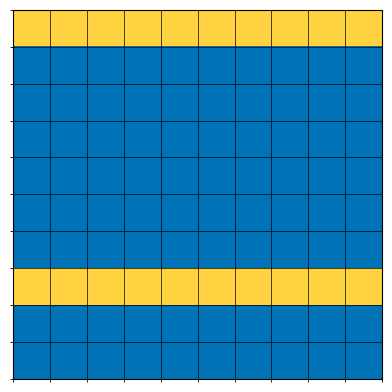

In [4]:
input_pattern = input[0, 0]

plt.imshow(input_pattern.reshape((-1, 10)), cmap=blue_yellow, vmin=0, vmax=1)

# --- Grid setup ---
# Set minor ticks at pixel boundaries
plt.xticks(np.arange(-0.5, 10, 1), minor=True)
plt.yticks(np.arange(-0.5, 10, 1), minor=True)
# Draw gridlines at minor ticks
plt.grid(which="minor", color="black", linestyle='-', linewidth=0.5)

plt.xticks([])
plt.yticks([])

plt.savefig("Figures/SVG/11C1.svg", dpi=300, transparent=True)
plt.show()

In [5]:
num_swaps = 4

input_pattern_corrupted = get_sample_from_num_swaps(input_pattern, num_swaps, network.hidden_subregions)

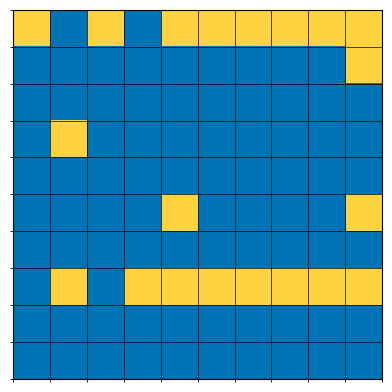

In [6]:
plt.imshow(input_pattern_corrupted.reshape((-1, 10)), cmap=blue_yellow, vmin=0, vmax=1)

# --- Grid setup ---
# Set minor ticks at pixel boundaries
plt.xticks(np.arange(-0.5, 10, 1), minor=True)
plt.yticks(np.arange(-0.5, 10, 1), minor=True)

# Draw gridlines at minor ticks
plt.grid(which="minor", color="black", linestyle='-', linewidth=0.5)

plt.xticks([])
plt.yticks([])

plt.savefig("Figures/SVG/11C2.svg", dpi=300, transparent=True)
plt.show()

In [7]:
latent_specs["prob_list"] = [0.2 if (i, j) == (0, 0) else 0 if i == 0 and j >0 else 0.8/20 for i in range(5) for j in range(5)]
input_parameters["latent_space"] = LatentSpace(**latent_specs)

In [8]:
sim_cond_matrix, th_cond_matrix = get_cond_matrix(input_parameters["latent_space"], np.array(network.hidden_hidden), 1)

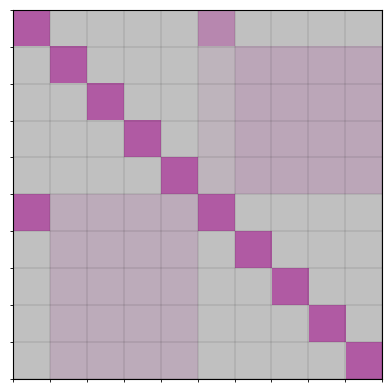

In [9]:
plt.imshow(th_cond_matrix.reshape((10, 10)), cmap=gray_purple, vmin=0, vmax=1)

# Set ticks at pixel boundaries
plt.xticks(np.arange(-0.5, 10, 1), minor=True)
plt.yticks(np.arange(-0.5, 10, 1), minor=True)
plt.grid(which="minor", color="black", linestyle='-', linewidth=0.1)


plt.xticks([])
plt.yticks([])
plt.savefig("Figures/SVG/12C.svg", dpi=300, transparent=True)

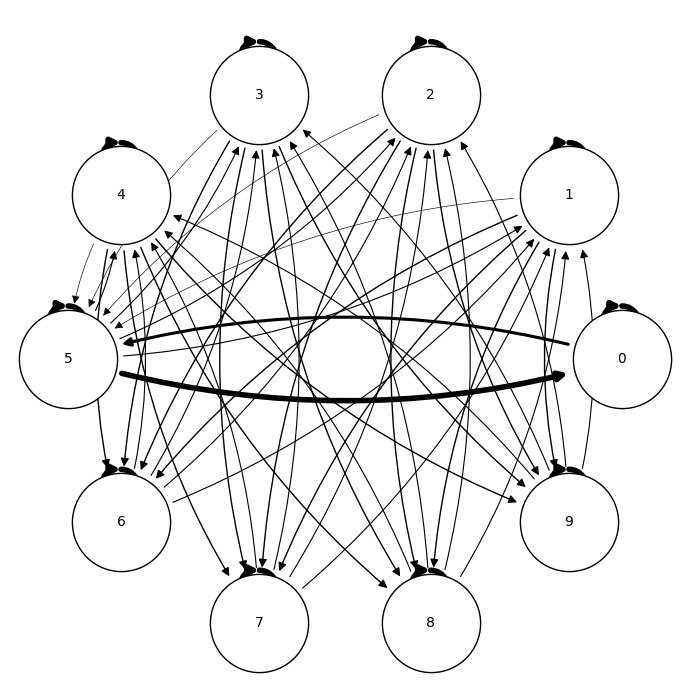

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

A = th_cond_matrix

labels = np.arange(10)
G = nx.from_numpy_array(A, create_using=nx.DiGraph)
nx.relabel_nodes(G, {i: labels[i] for i in range(len(labels))}, copy=False)

pos = nx.circular_layout(G)

weights = [d["weight"] for _, _, d in G.edges(data=True)]
widths = [0 + 4*w/max(weights) for w in weights]

fig, ax = plt.subplots(figsize=(7, 7))

# Nodes a bit smaller
nx.draw_networkx_nodes(G, pos, node_size=5000, node_color="white", edgecolors="black", ax=ax)
nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)

# Arrows bigger and slightly curved so the head is visible
nx.draw_networkx_edges(
    G, pos,
    width=widths,
    arrows=True,
    arrowsize=12,
    arrowstyle='-|>',
    connectionstyle="arc3,rad=0.15",
    edge_color="black",
    ax=ax,
    min_source_margin=40,   # keep arrow away from source node
    min_target_margin=40    # stop arrow at node boundary, not inside
)

ax.set_axis_off()

plt.tight_layout()
plt.savefig("Figures/SVG/12B.svg", dpi=300, transparent=True)